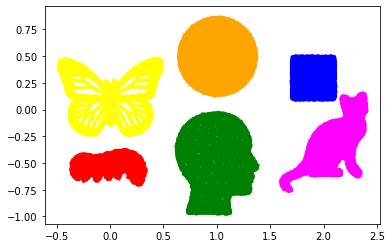

In [250]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

  0%|          | 1/901 [00:00<10:50,  1.38it/s]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 1.4142) (lr: 0.0001) (n_subsample: 300) 
(time elapsed: 0.7204) (total time: 0.7222) (fit time: 0.1670) (reg loss time: 0.0803) (savetime: 0.0000) (steptime: 0.4713)


  6%|▌         | 51/901 [01:00<1:01:34,  4.35s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.1963) (lr: 0.0001) (n_subsample: 378) 
(time elapsed: 49.0884) (total time: 60.4434) (fit time: 0.2126) (reg loss time: 0.1576) (savetime: 10.6283) (steptime: 0.8402)


 11%|█         | 101/901 [02:10<58:48,  4.41s/it] 

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0494) (lr: 0.0001) (n_subsample: 476) 
(time elapsed: 59.3983) (total time: 130.3704) (fit time: 0.2224) (reg loss time: 0.1486) (savetime: 10.5241) (steptime: 0.8449)


 17%|█▋        | 151/901 [03:28<57:15,  4.58s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0389) (lr: 0.0001) (n_subsample: 600) 
(time elapsed: 67.0194) (total time: 208.1003) (fit time: 0.2485) (reg loss time: 0.1721) (savetime: 10.7066) (steptime: 0.9468)


 22%|██▏       | 201/901 [04:51<55:26,  4.75s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0308) (lr: 0.0001) (n_subsample: 756) 
(time elapsed: 72.9464) (total time: 291.8846) (fit time: 0.2636) (reg loss time: 0.2154) (savetime: 10.8339) (steptime: 1.0515)


 28%|██▊       | 251/901 [06:18<52:17,  4.83s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0236) (lr: 0.0001) (n_subsample: 953) 
(time elapsed: 75.9888) (total time: 378.7204) (fit time: 0.2898) (reg loss time: 0.1764) (savetime: 10.8420) (steptime: 1.0495)


 33%|███▎      | 301/901 [07:50<49:36,  4.96s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0262) (lr: 0.0001) (n_subsample: 1100) 
(time elapsed: 80.7203) (total time: 470.2924) (fit time: 0.3092) (reg loss time: 0.2068) (savetime: 10.8484) (steptime: 1.1640)


 39%|███▉      | 351/901 [09:27<45:53,  5.01s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0253) (lr: 5e-05) (n_subsample: 1100) 
(time elapsed: 85.9715) (total time: 567.1550) (fit time: 0.3012) (reg loss time: 0.2071) (savetime: 10.8865) (steptime: 1.1610)


 45%|████▍     | 401/901 [11:15<44:11,  5.30s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0247) (lr: 5e-05) (n_subsample: 1100) 
(time elapsed: 97.3591) (total time: 675.5722) (fit time: 0.3732) (reg loss time: 0.3213) (savetime: 11.0552) (steptime: 1.5910)


 50%|█████     | 451/901 [13:19<42:47,  5.70s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0223) (lr: 5e-05) (n_subsample: 1100) 
(time elapsed: 112.8525) (total time: 799.5967) (fit time: 0.4499) (reg loss time: 0.3250) (savetime: 11.1688) (steptime: 1.6862)


 56%|█████▌    | 501/901 [15:28<38:30,  5.78s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0182) (lr: 5e-05) (n_subsample: 1100) 
(time elapsed: 118.2451) (total time: 928.8638) (fit time: 0.4013) (reg loss time: 0.3634) (savetime: 11.0190) (steptime: 1.7982)


 61%|██████    | 551/901 [17:37<32:55,  5.65s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0316) (lr: 5e-05) (n_subsample: 1100) 
(time elapsed: 117.8934) (total time: 1057.7877) (fit time: 0.4155) (reg loss time: 0.2019) (savetime: 11.0272) (steptime: 1.4748)


 67%|██████▋   | 601/901 [19:43<28:01,  5.60s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0235) (lr: 2.5e-05) (n_subsample: 1100) 
(time elapsed: 114.4583) (total time: 1183.2962) (fit time: 0.4116) (reg loss time: 0.2793) (savetime: 11.0470) (steptime: 1.6346)


 72%|███████▏  | 651/901 [21:50<23:13,  5.57s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0146) (lr: 2.5e-05) (n_subsample: 1100) 
(time elapsed: 115.8982) (total time: 1310.1321) (fit time: 0.4090) (reg loss time: 0.3262) (savetime: 10.9337) (steptime: 1.6308)


 78%|███████▊  | 701/901 [23:59<18:48,  5.64s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0153) (lr: 2.5e-05) (n_subsample: 1100) 
(time elapsed: 118.7586) (total time: 1439.9279) (fit time: 0.4081) (reg loss time: 0.3524) (savetime: 11.0329) (steptime: 1.7681)


 83%|████████▎ | 751/901 [26:07<14:00,  5.60s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0151) (lr: 1.25e-05) (n_subsample: 1100) 
(time elapsed: 116.8846) (total time: 1567.9040) (fit time: 0.4184) (reg loss time: 0.3123) (savetime: 11.0871) (steptime: 1.6633)


 89%|████████▉ | 801/901 [28:17<09:26,  5.67s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0165) (lr: 1.25e-05) (n_subsample: 1100) 
(time elapsed: 118.6572) (total time: 1697.7509) (fit time: 0.4110) (reg loss time: 0.3738) (savetime: 11.1851) (steptime: 1.7165)


 94%|█████████▍| 851/901 [30:24<04:34,  5.48s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0134) (lr: 1.25e-05) (n_subsample: 1100) 
(time elapsed: 115.8736) (total time: 1824.6000) (fit time: 0.4018) (reg loss time: 0.2778) (savetime: 10.9720) (steptime: 1.5640)


100%|██████████| 901/901 [32:33<00:00,  2.17s/it]

Allocated: 0.02 GB  Reserved: 1.14 GB
(loss: 0.0155) (lr: 1.25e-05) (n_subsample: 1100) 
(time elapsed: 117.5489) (total time: 1953.1247) (fit time: 0.4221) (reg loss time: 0.3611) (savetime: 10.9722) (steptime: 1.6952)


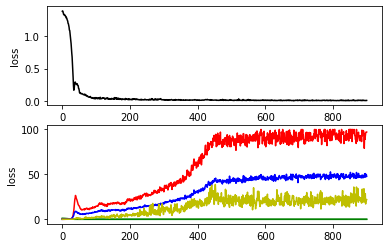

In [253]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 8, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2).to(device); 
outfolder = "results/experiment1a/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 201, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)
st.save_losses(losses, separate_losses, outfolder=outfolder)

model = FfjordModel(sigmac = 8, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2).to(device); 
outfolder = "results/experiment1b/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 201, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=False)
st.save_losses(losses, separate_losses, outfolder=outfolder)

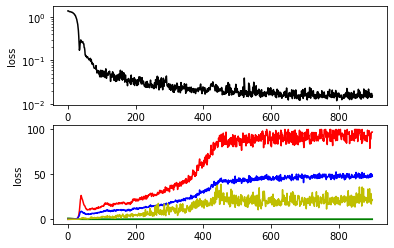

In [267]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
st.save_losses(losses, separate_losses, outfolder=outfolder)

FileNotFoundError: [Errno 2] No such file or directory: 'results/experiment4/losses.pdf'

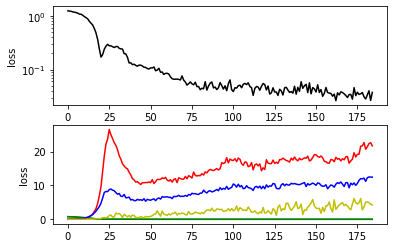

In [268]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
st.save_losses(losses, separate_losses, outfolder=outfolder, start = 15 , end = 200)